# **Proyecto Final Ingeniería Software III**


*   **Kevin Dannie Guzmán Duran**
*   **Juan Diego Roa Porras**

**Repo**: https://github.com/JuanRoa785/PF-Software-III/


# **Introducción**

Este proyecto se enfocó en el análisis empírico del comportamiento de una aplicación al ser desplegada en distintos entornos. Se utilizó como caso de estudio el proyecto final de la asignatura Entornos de Programación, evaluando su rendimiento tanto en Docker como en Kubernetes.

Las pruebas se llevaron a cabo en equipos con recursos limitados, proporcionados por la universidad, y también en un entorno con mayor capacidad de cómputo. Se variaron factores como el número de réplicas y la cantidad de nodos activos dentro del clúster de Kubernetes, con el fin de observar cómo estos elementos afectan el desempeño de la aplicación.

Aunque se trata de un análisis empírico, se procuró mantener condiciones consistentes en cada experimento para garantizar resultados comparables. Las métricas obtenidas sirvieron como base para las conclusiones que se presentan más adelante.



# **Objetivos**

El principal objetivo de este proyecto es aplicar de manera práctica los conocimientos adquiridos a lo largo del curso, configurando y utilizando activamente el clúster de máquinas virtuales provisto al inicio del semestre. Se buscó desplegar aplicaciones de forma eficiente y sencilla utilizando tanto Docker como Kubernetes.

Adicionalmente, con el propósito de fortalecer la capacidad analítica y mejorar la toma de decisiones técnicas, se llevaron a cabo pruebas de carga bajo diferentes configuraciones de la aplicación. Estas pruebas permitieron comparar empíricamente las alternativas de despliegue disponibles, aprovechando los recursos limitados del entorno, y así fundamentar con datos sólidos cuál opción resulta más conveniente.

# **Not An Ebook**

<p align="justify">
<b>Not An Ebook</b> es la aplicación desarrollada como proyecto final para la asignatura de Entornos de Programación en la Universidad Industrial de Santander. Su propósito es establecer los fundamentos de un sistema de comercio electrónico enfocado en la venta de libros físicos. La plataforma permite a los usuarios registrarse, consultar información clave de los libros, como sinopsis, autor, género literario, número de páginas, entre otros, y simular una compra ingresando su dirección.

Asimismo, los administradores del emprendimiento pueden acceder a reportes de ventas utilizando filtros simples e intuitivos. Con el objetivo de escalar la aplicación, se contempla la implementación de funcionalidades avanzadas de gestión de inventario, permitiendo que el sistema evolucione hacia una solución de información en tiempo real que proporcione a los administradores datos relevantes sobre la rentabilidad del negocio.
</p>

## **Tecnologías Utilizadas**

*   **Backend:** Spring Boot
*   **Frontend:** Angular
*   **Database:** PostgreSQL
*   **Gestión de Imagenes:** Cloudinary

## **Software en Ejecución**

<p align="center">
  <img src="https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Assets/notanebook.gif" width="800"/>
</p>








---

# **Configuración de Despliegue**

La configuración del despliegue se basó en el uso de **variables de entorno**, lo que permitió adaptar la ejecución del software a diferentes entornos modificando únicamente sus valores. Gracias a este enfoque, la aplicación pudo ejecutarse y ser accesible tanto de forma local como en un cluster de máquinas virtuales sin la necesidad de realizar cambios en el código fuente.

## **Database (PostgreSQL)**
La configuración de la base de datos se mantuvo constante en todos los despliegues, utilizando las siguientes variables de entorno:

```dockerfile
ENV POSTGRES_USER=postgres
ENV POSTGRES_PASSWORD=adminPostgres
ENV POSTGRES_DB=not_an_ebook
```
Es importante destacar que el valor de `POSTGRES_DB` no debe ser modificado, ya que el backend tiene este nombre de base de datos codificado de forma fija. En caso de cambiarlo, será necesario ajustar el archivo `application.properties` del backend, reconstruir la imagen con `docker build` y, para mantener la coherencia en los despliegues, actualizar la imagen correspondiente en **Docker Hub**.

Aunque el servicio de PostgreSQL expone el puerto estándar **5432**, este fue mapeado al puerto **5435** en Docker y al **30543** en Kubernetes para evitar conflictos y facilitar el acceso según el entorno de ejecución.

## **Backend (Spring Boot)**

A continuación se presentan las variables de entorno definidas en el archivo `application.properties` del backend:

```java
spring.datasource.url=jdbc:postgresql://${DB_HOST}:${DB_PORT}/not_an_ebook
spring.datasource.username=${DB_USER}
spring.datasource.password=${DB_PASS}
spring.jpa.show-sql=true
server.port = 8081

spring.servlet.multipart.max-file-size=10MB
spring.servlet.multipart.max-request-size=10MB

cloudinary.cloud-name=${CLOUD_NAME}
cloudinary.api-key=${CLOUD_API_KEY}
cloudinary.api-secret=${CLOUD_API_SECRET}
```

Estas variables permiten establecer la conexión con la base de datos PostgreSQL y habilitar el servicio de Cloudinary para la gestión de las portadas de los libros. Además, se configura el puerto del servidor y se definen límites para la carga de archivos, lo que facilita una configuración flexible y adaptable a diferentes entornos de despliegue.

## **Frontend (Angular -> Nginx)**

El despliegue de la aplicación frontend desarrollada en Angular presentó ciertos desafíos adicionales. Uno de los principales fue la necesidad de definir una única variable de entorno: la URL base para realizar peticiones al backend. Esta configuración se complica especialmente en entornos distribuidos como Kubernetes, donde no se puede predecir en qué nodo estarán desplegadas las réplicas del backend en un momento dado.

Para resolver esta problemática, se configuró y utilizó un ingress controller, el cual actúa como proxy inverso para enrutar las peticiones entrantes. La configuración específica se definió en el archivo ingress-config.yaml.

Además, para simplificar el proceso de creación de la imagen del frontend, se utilizó el comando:

```shell
npm run build --omit=dev
```

Este comando compila la aplicación en su versión de producción. Durante el proceso de construcción de la imagen Docker, el archivo `index.html` está diseñado para consumir un archivo `config.js`, el cual se genera dinámicamente mediante el script `docker-entrypoint.sh.` Este script sobrescribe `config.js` con los valores apropiados según la estrategia de despliegue. Su lógica principal es la siguiente:

```shell
if [ "$DEPLOY_TYPE" = "kubernetes" ]; then
  echo "window.API_URL = '${API_URL}';" > $CONFIG_PATH
else
  echo "window.API_URL = 'http://${BACKEND_HOST}:${BACKEND_PORT}';" > $CONFIG_PATH
fi
```
En esta lógica se observa que, para despliegues con Docker, es necesario especificar el host y el puerto del backend (por ejemplo: `10.6.101.100:8081`). En cambio, para Kubernetes, basta con usar el alias definido en el Ingress (en este caso: `backend.local`), ya que el enrutamiento es gestionado automáticamente dentro del clúster.

## **Docker Hub**
Una vez verificado que las imágenes funcionaban correctamente tanto en entornos Docker como en Kubernetes, se realizó el push final de estas al repositorio de Docker Hub, asegurando así su disponibilidad para los diferentes escenarios de despliegue.

<p align="center">
  <img src="https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Assets/dockerhub.png" width="700"/>
</p>

Cabe resaltar que, debido a la similitud estructural entre esta aplicación y la desplegada en el Reto 2, fue posible reutilizar gran parte de los `Dockerfile` y archivos `.yaml` utilizados anteriormente, lo cual facilitó y agilizó el proceso de configuración y despliegue.



---



# **Despliegue de Not An Ebook**

```shell
#Clonar el repositorio
git clone https://github.com/JuanRoa785/PF-Software-III.git

#Ubicarse en el directorio del proyecto
cd PF-Software-III
```

## **Docker**
En caso de no ejecutar la aplicación de forma completamente local, es necesario actualizar en el archivo `docker-compose.yml` la variable de entorno `BACKEND_HOST`, asignándole la IP de la máquina virtual donde se desplegarán los contenedores.

Para levantar la aplicación, ejecuta los siguientes comandos:

```shell
docker compose up -d
docker ps # Verifica que los tres contenedores estén en ejecución
```

Una vez desplegado, los servicios estarán disponibles en las siguientes direcciones:

*   **Fronted:** `http://IP_MAQUINA:4200`
*   **Backend:** `http://IP_MAQUINA:8081`
*   **Database:** `IP_MAQUINA:30543`

Para detener la aplicación, simplemente ejecuta:
```shell
docker compose down
```

---

## **Kubernetes**
Para desplegar la aplicación en Kubernetes, primero asegúrate de estar ubicado en la carpeta `k8s/configs` y habilita el complemento `ingress` con los siguientes comandos:

```shell
microk8s kubectl enable ingress
cd k8s/configs
```
> 💡 Si tu clúster cuenta con varios nodos y se crea una réplica del controlador `ingress` por nodo, es recomendable editar su deployment para limitarlo a una sola réplica por clúster, evitando conflictos

Luego, aplica los `ConfigMaps` y `Secrets` necesarios para preparar tanto el despliegue como el Ingress:
```shell
microk8s kubectl apply -f .
```
### **Configuración de alias en la máquina local**
Para acceder a la aplicación o realizar pruebas desde la máquina local (por ejemplo, con JMeter o mediante navegador), debes crear un alias llamado `backend.local` apuntando a la IP del nodo donde se está ejecutando `ingress`. Para identificar la IP:
```shell
microk8s kubectl describe pods -n ingress
```

Busca una sección similar a esta en el resultado:
```shell
Node: roa-pc/192.168.1.12
```

Luego, edita el archivo de hosts:
```shell
sudo nano /etc/hosts
```

Y añade la siguiente línea:
```lua
192.168.1.12    backend.local
```
### **Despliegue de los servicios**
Finalmente, regresa a la carpeta principal (k8s/) y ejecuta los archivos de deployment y servicios:
```shell
cd ../
microk8s kubectl apply -f .
```

Una vez desplegados, los servicios estarán disponibles en los siguientes puertos:

*   **Frontend:** `http://IP_MAQUINA:30420`
*   **Backend:** `http://IP_MAQUINA:30081`
*   **Database:** `IP_MAQUINA:30543`





---




# **Metodología de Generación de Carga con JMeter**

Antes de abordar la prueba de estrés realizada con JMeter, es importante describir el estado inicial de la base de datos. Independientemente de la herramienta de despliegue utilizada, la aplicación se inicializa con los siguientes datos por defecto:

*   **75** Productos (Libros)
*   **100** Usuarios
*   **100** Direcciones
*   **1500** Ventas
*   **3700** Detalles de Ventas

<p align="center">
  <img src="https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Assets/database.gif" width="800"/>
</p>

---

El endpoint seleccionado para la prueba fue el del reporte individual, ya que es, sin duda, el que mayor carga genera tanto para el backend como para la base de datos. Este endpoint recibe los siguientes parámetros:

*  **cliente**: nombre del cliente, utilizado para filtrar las ventas en las que haya participado como comprador.
*  **fechaInferior**: límite inferior del rango de fechas para mostrar las ventas.
*  **fechaInferior**: límite superior del rango de fechas para mostrar las ventas.
*  **totalDesc**:  parámetro que permite ordenar las ventas según su total.

En la interfaz del frontend, este formulario se visualiza de la siguiente manera:
<p align="center">
  <img src="https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Assets/reporte.png" width="800"/>
</p>

Y su configuración equivalente en JMeter se muestra así:
<p align="center">
  <img src="https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Assets/jmeter.png" width="800"/>
</p>

Para estas pruebas, se dejó el parámetro cliente como cadena vacía, se fijó el **límite inferior** en el 1 de enero de 2020 y el **límite superior** en la fecha actual. De este modo, se garantiza que se consulten las **1500** ventas registradas, asegurando así que la carga generada por el endpoint sea significativa.



---



# **Obtención de los datos**

Para garantizar la fiabilidad de los resultados durante las pruebas de carga, se siguió una metodología rigurosa desde la máquina local encargada de ejecutarlas. El primer paso fue detener cualquier servicio innecesario que pudiera interferir en el rendimiento, incluyendo los entornos de **Docker** y **MicroK8s**, mediante los siguientes comandos:

```shell
sudo systemctl stop docker
sudo microk8s stop
```

Posteriormente, se accedió a las máquinas del clúster de Kubernetes y se minimizaron los procesos en ejecución, deteniendo todos los deployments, servicios o contenedores que pudieran estar activos y consumir recursos.

En la máquina local, se aseguró que no se estuviera ejecutando ningún otro proceso aparte de JMeter, una consola con conexión SSH al clúster, y el navegador Brave con solo un par de pestañas abiertas.

Además, fue necesario ajustar los límites de consumo de recursos por parte de JMeter. Para ello, se editó el archivo `setenv.sh` con las siguientes configuraciones:

```shell
sudo nano /opt/apache-jmeter-5.6.3/bin/setenv.sh
export HEAP="-Xms2g -Xmx4g -XX:MaxMetaspaceSize=512m"
```

Cabe destacar que, durante toda la ejecución de las pruebas, el uso de recursos de la máquina local no superó en ningún momento el **50%**, lo cual garantiza que los resultados obtenidos no estuvieron condicionados por cuellos de botella a nivel de hardware.

## **Fase 1**
Al igual que en la máquina local, se detuvo el servicio de MicroK8s utilizando el comando previamente mencionado. Además, se procedió a limpiar completamente el entorno de Docker, eliminando todos los contenedores e imágenes existentes con los siguientes comandos:

```shell
docker stop $(docker ps -a -q)
docker rm $(docker ps -a -q)
docker rmi $(docker images -q)
```
Para cada configuración se realizaron cuatro experimentos, cuyos resultados fueron posteriormente promediados. Las configuraciones evaluadas fueron las siguientes:

|# Replicas | Ramp up | # Samples|
|-----------|---------|----------|
|     1     |    50   |   100    |
|     1     |   100   |   300    |
|     1     |   100   |   700    |
|     1     |   100   |   1000   |

## **Fase 2**
En esta fase se cambió de máquina dentro del clúster. Mientras que la Fase 1 se ejecutó en la máquina `10.6.101.107`, al finalizar dicha etapa se detuvieron sus servicios de Docker y no se reinició MicroK8s en ella. Posteriormente, se continuó en la máquina `10.6.101.100`, reiniciando el servicio de Kubernetes con el siguiente comando:

```shell
sudo microk8s start
```

Para asegurar que el nodo `107` no participara en esta fase, se verificó que estuviera deshabilitado. Además, como medida adicional, se lo acordonó con:

```shell
microk8s kubectl cordon student107
```

Cada vez que se modificaba el archivo `pfs-back-deployment.yaml` para cambiar la cantidad de réplicas del backend, se comprobaba **que todos los pods se estuvieran ejecutando exclusivamente en la máquina 100**.

A diferencia de la Fase 1 y debido a limitaciones de tiempo, en esta fase se realizaron **2 experimentos por configuración**. Las configuraciones evaluadas fueron:

|# Replicas | Ramp up | # Samples|
|-----------|---------|----------|
|     1     |    50   |   100    |
|     1     |   100   |   300    |
|     1     |   100   |   700    |
|     1     |   100   |   1000   |
|     2     |    50   |   100    |
|     2     |   100   |   300    |
|     2     |   100   |   700    |
|     2     |   100   |   1000   |
|     3     |    50   |   100    |
|     3     |   100   |   300    |
|     3     |   100   |   700    |
|     3     |   100   |   1000   |

## **Fase 3**

Tras habilitar nuevamente MicroK8s en el nodo `107` y desacordonarlo mediante el siguiente comando:

```shell
microk8s kubectl uncordon student107
```

Se eliminaron los pods desplegados hasta lograr la siguiente distribución inicial: **la base de datos ubicada en la máquina 107 y la primera réplica del backend en la máquina 100**. A medida que se aumentaba el número de réplicas del backend, se verificó que hubiera una **réplica por nodo**.

Para las últimas cuatro configuraciones, en las que se utilizaban **tres réplicas del backend**, ya no era relevante en qué nodo se desplegaba la tercera réplica, ya que inevitablemente uno de los nodos terminaría sobrecargado.

Al igual que en la Fase 2, se evaluaron las mismas **12 configuraciones**, con 2 experimentos por cada una, sumando un total de **24 ejecuciones** en esta fase

## **Fase 4**
En esta fase se planteó un análisis adicional repitiendo un único experimento por configuración, pero con una condición particular: **la máquina que ejecutaba la aplicación tenía especificaciones significativamente superiores**, y además, **JMeter se ejecutaba en esa misma máquina**, eliminando así cualquier latencia de red entre el generador de carga y el sistema bajo prueba.

|Despliegue |# Replicas | Ramp up | # Samples|
|-----------|-----------|---------|----------|
|   Docker  |     1     |    50   |   100    |
|   Docker  |     1     |   100   |   300    |
|   Docker  |     1     |   100   |   700    |
|   Docker  |     1     |   100   |   1000   |
|  Microk8s |     1     |    50   |   100    |
|  Microk8s |     1     |   100   |   300    |
|  Microk8s |     1     |   100   |   700    |
|  Microk8s |     1     |   100   |   1000   |

Lamentablemente, los resultados obtenidos fueron inconsistentes, por lo que no se profundizó su análisis.



---



# **Creación del Dataset**
Dado que las métricas de interés estaban disponibles en el **Summary Report de JMeter**, se exportaron y almacenaron en el directorio `Jmeter/Experimentos`, tal como se muestra a continuación:

<p align="center">
  <img src="https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Assets/ovwExp.png" width="800"/>
</p>

Como todos los archivos `.csv` generados compartían la misma estructura, se elaboró un script sencillo llamado `formatCSV.sh`. Este script iteraba por cada archivo CSV, extraía únicamente la **segunda línea** (que contiene los valores de las métricas), y las concatenaba en un único archivo denominado `resultados.csv`.

Este archivo consolidado sirvió como punto de partida para el preprocesamiento de los datos, descrito en la siguiente sección.

# **Tratamiento del Dataset**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Jmeter/resultados.csv')

#Creamos un nuevo dataset donde iran los datos tratados
df_tratado = pd.DataFrame()

# Limpiar y convertir la columna 'Error %' a tipo numérico
df['Error %'] = df['Error %'].astype(str).str.strip().str.replace('%', '', regex=False)
df['Error %'] = pd.to_numeric(df['Error %'], errors='coerce')

# Eliminar la columna 'Label'
df_numeric = df.drop(columns=["Label"])

#print(df_numeric.dtypes)

df_numeric

,# Samples,Average,Min,Max,Std. Dev.,Error %,Throughput,Received KB/sec,Sent KB/sec,Avg. Bytes
0,100,4323,1172,14516,2876.43,0.000,1.58672,8754.20,0.33,5649571.0
1,100,6147,1723,17035,2509.53,0.000,1.81548,10016.27,0.38,5649571.0
2,100,2286,1190,4549,504.60,0.000,1.93615,10682.03,0.41,5649571.0
3,100,3350,1592,16087,2663.07,0.000,1.70625,9413.66,0.36,5649571.0
4,300,28803,1692,42228,9234.02,24.333,2.22188,9275.84,0.47,4274970.5
...,...,...,...,...,...,...,...,...,...,...
67,1000,11686,839,30038,8610.78,0.200,7.90658,43534.60,1.64,5638272.9
68,100,982,821,2283,193.19,0.000,1.98484,10950.66,0.42,5649571.0
69,300,904,836,1007,33.92,0.000,2.98291,16457.18,0.63,5649571.0
70,700,723,579,1111,79.29,0.000,6.95459,38369.56,1.47,5649571.0


In [3]:
#Promediar los 4 experimentos por configuración de la fase 1
df_fase1 = df_numeric[0:16]

for i in range(0, len(df_fase1), 4):
    bloque = df_fase1.iloc[i:i+4]
    promedio = bloque.mean()
    df_tratado = pd.concat([df_tratado, promedio.to_frame().T], ignore_index=True)

#df_tratado

#----------------------------------------------------------------------------------

#Promediar los 2 experimentos por cada configuración de la fase 2 y 3
df_k8s = df_numeric[16:64]

for i in range(0, len(df_k8s), 2):
    bloque = df_k8s.iloc[i:i+2]
    promedio = bloque.mean()
    df_tratado = pd.concat([df_tratado, promedio.to_frame().T], ignore_index=True)

#df_tratado

#----------------------------------------------------------------------------------

#Concatenar los experimentos de la fase 4 (1 por configuración)
df_fase4 = df_numeric[64:]
df_tratado = pd.concat([df_tratado, df_fase4], ignore_index=True)
#df_tratado


In [4]:
# Definir los valores de las columnas de metadatos
fase = [
    1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
    2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
    3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4
]

replicas = [
    1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3,
    1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3,
    1, 1, 1, 1, 1, 1, 1, 1
]

ramp_up = [
    50, 100, 100, 100, 50, 100, 100, 100, 50, 100, 100, 100,
    50, 100, 100, 100, 50, 100, 100, 100, 50, 100, 100, 100,
    50, 100, 100, 100, 50, 100, 100, 100, 50, 100, 100, 100
]

# Crear un DataFrame con esas columnas
metadata_df = pd.DataFrame({
    'Fase': fase,
    '# Replicas': replicas,
    'Ramp up': ramp_up
})

# Añadir al DataFrame existente
df_tratado.insert(0, 'Ramp up', metadata_df['Ramp up'])
df_tratado.insert(0, '# Replicas', metadata_df['# Replicas'])
df_tratado.insert(0, 'Fase', metadata_df['Fase'])

#df_tratado

In [5]:
#Formatear (redondear) las columnas para que se parezcan al df original:
# Redondear columnas específicas
df_tratado['# Samples'] = df_tratado['# Samples'].round(0).astype(int)
df_tratado['Average'] = df_tratado['Average'].round(0).astype(int)
df_tratado['Min'] = df_tratado['Min'].round(0).astype(int)
df_tratado['Max'] = df_tratado['Max'].round(0).astype(int)
df_tratado['Std. Dev.'] = df_tratado['Std. Dev.'].round(2)
df_tratado['Error %'] = df_tratado['Error %'].round(4)
df_tratado['Throughput'] = df_tratado['Throughput'].round(6)
df_tratado['Received KB/sec'] = df_tratado['Received KB/sec'].round(2)
df_tratado['Sent KB/sec'] = df_tratado['Sent KB/sec'].round(2)
df_tratado['Avg. Bytes'] = df_tratado['Avg. Bytes'].round(2)

df_tratado.to_csv('resultadosTratados.csv', index=False)

df_tratado

,Fase,# Replicas,Ramp up,# Samples,Average,Min,Max,Std. Dev.,Error %,Throughput,Received KB/sec,Sent KB/sec,Avg. Bytes
0,1,1,50,100,4026,1419,13047,2138.41,0.0000,1.761150,9716.54,0.37,5649571.00
1,1,1,100,300,25866,1785,41482,9980.33,17.1665,2.248670,10280.64,0.47,4679818.60
2,1,1,100,700,32610,3324,44270,7053.61,62.3212,4.968810,10331.03,1.04,2129006.70
3,1,1,100,1000,49765,3665,85493,17008.30,68.6750,5.600060,9677.26,1.17,1770090.72
4,2,1,50,100,16063,4840,24444,5134.28,0.0000,1.395600,7699.74,0.30,5649571.00
5,2,1,100,300,29486,2758,41857,8672.86,36.6665,2.196150,7673.20,0.46,3578255.25
6,2,1,100,700,33719,4909,53165,6409.44,71.7140,4.819155,7521.86,1.02,1598400.15
7,2,1,100,1000,52032,5193,85909,16976.94,75.6000,5.517870,7430.70,1.16,1378894.50
8,2,2,50,100,24705,3708,43416,9427.47,3.0000,1.176380,6306.54,0.24,5480099.70
9,2,2,100,300,35409,3692,69998,10966.79,45.1670,2.118485,6412.36,0.44,3098086.60




---



# **Graficas**

## **Importar librerias**

In [6]:
# Importar librerias
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# **Fase 1**

## **Desviacón estándar del tiempo de Respuesta**

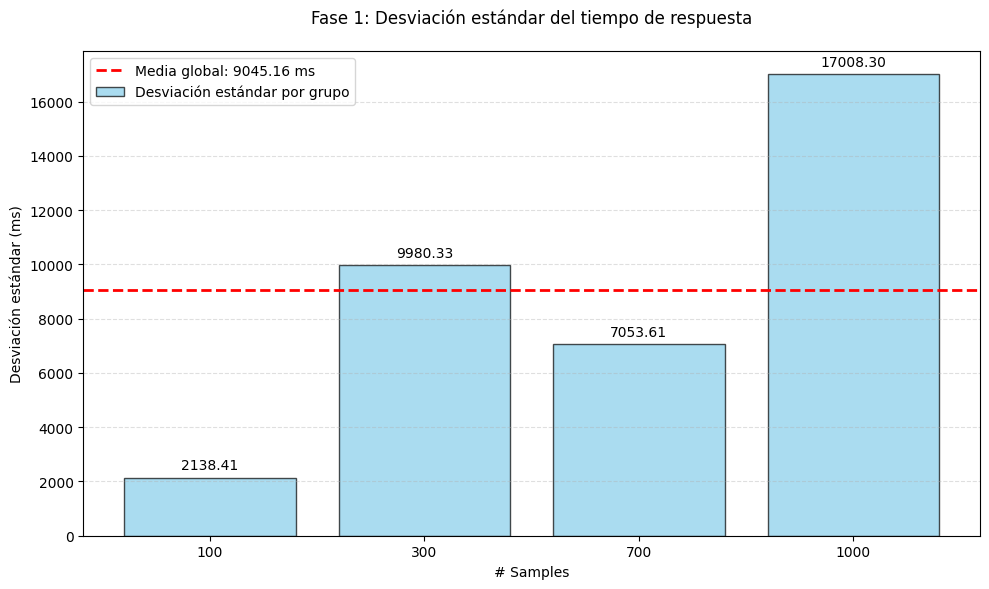

In [7]:
# Cargar datos
df = pd.read_csv('https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Jmeter/resultadosTratados.csv')

df = df[df['Fase'] == 1]

# Calcular la media global de la desviación estándar
mean_std = df['Std. Dev.'].mean()

# Crear gráfico
plt.figure(figsize=(10, 6))

# Gráfico de barras
bars = plt.bar(
    x=df['# Samples'].astype(str),
    height=df['Std. Dev.'],
    color='skyblue',
    edgecolor='black',
    alpha=0.7,
    label='Desviación estándar por grupo'
)

# Línea horizontal para la media global
plt.axhline(
    y=mean_std,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Media global: {mean_std:.2f} ms'
)

# Añadir etiquetas a las barras
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 200,
        f'{height:.2f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# Personalización
plt.title('Fase 1: Desviación estándar del tiempo de respuesta', pad=20)
plt.xlabel('# Samples')
plt.ylabel('Desviación estándar (ms)')
plt.xticks(rotation=0)
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## **Promedio de Error segun cantidad de muestras**

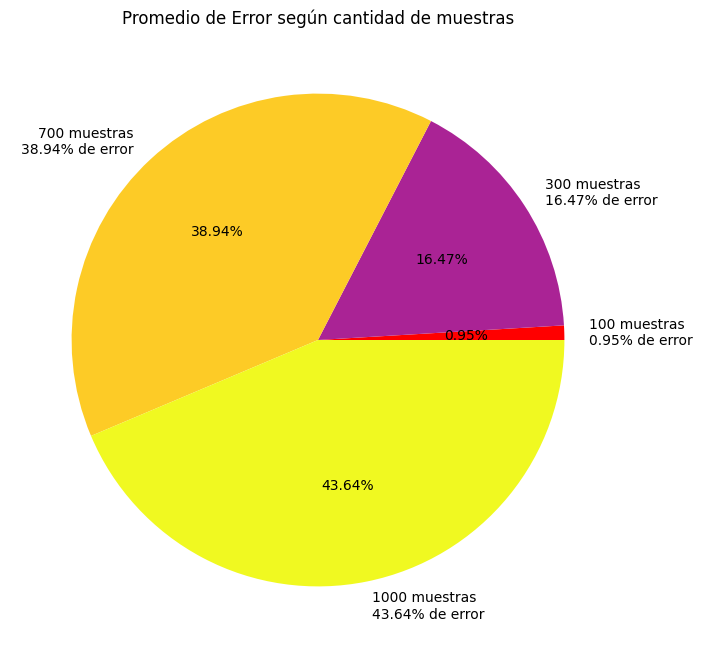

In [8]:
# Cargar los datos
df = pd.read_csv('https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Jmeter/resultadosTratados.csv')

# Limpiar y convertir la columna 'Error %' a tipo numérico
df['Error %'] = df['Error %'].astype(str).str.strip().str.replace('%', '', regex=False)
df['Error %'] = pd.to_numeric(df['Error %'], errors='coerce')

# Agrupar por cantidad de muestras y calcular el promedio del % de error
grouped_avg_error = df.groupby('# Samples')['Error %'].mean()

# Crear la gráfica de pastel
plt.figure(figsize=(8, 8))
colors = plt.cm.plasma(grouped_avg_error / grouped_avg_error.max())

# Convertir colors a lista para poder modificarlo
colors = list(colors)

# Obtener los valores y etiquetas en orden consistente
values = list(grouped_avg_error.values()) if isinstance(grouped_avg_error, dict) else grouped_avg_error.to_numpy()
labels = list(grouped_avg_error.keys()) if isinstance(grouped_avg_error, dict) else grouped_avg_error.index

# Encontrar el índice del mínimo error (asegurando que sea un índice numérico válido)
indice_menor_error = np.argmin(values)

# Cambiar el color de esa porción a ROJO
colors[indice_menor_error] = [1, 0, 0, 1]  # Rojo puro

total = sum(values)
plt.pie(values,
        labels=[f"{samples} muestras\n{(val/total)*100:.2f}% de error"
                for samples, val in zip(labels, values)],
        autopct='%1.2f%%',
        colors=colors)

plt.title('Promedio de Error según cantidad de muestras')
plt.show()

## **Throughput y tiempo de respuesta por número de muestras**

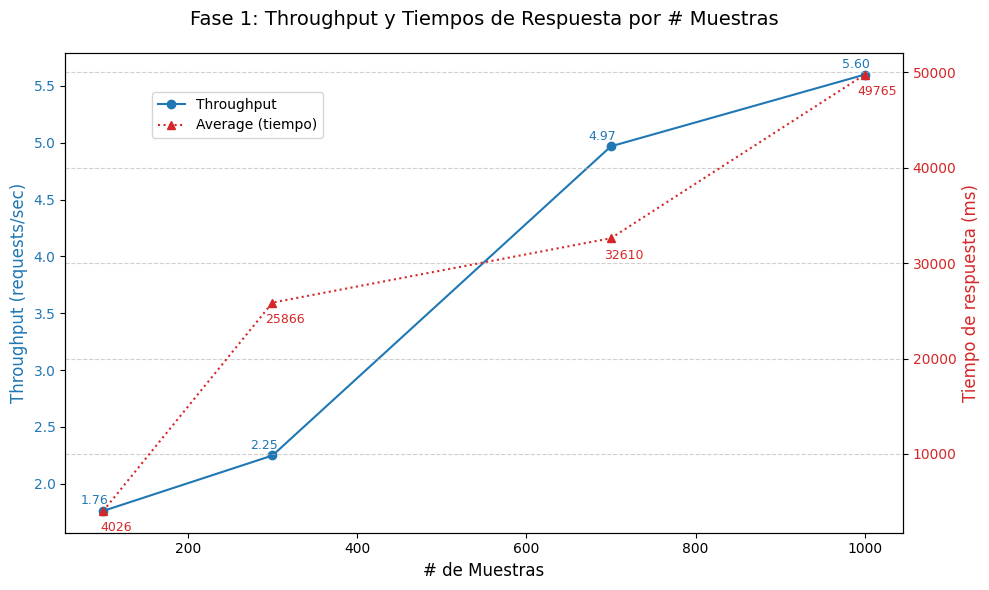

In [9]:
# Cargar los datos
df = pd.read_csv('https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Jmeter/resultadosTratados.csv')

# Filtrar solo los datos de la Fase 1
fase_1 = df[df['Fase'] == 1]

# Agrupar por '# Samples' y calcular promedios
grouped = fase_1.groupby('# Samples').agg({
    'Throughput': 'mean',
    'Average': 'mean'
}).sort_index()

# Crear figura con doble eje
fig, ax1 = plt.subplots(figsize=(10, 6))

# Eje Y izquierdo (Throughput)
ax1.set_xlabel('# de Muestras', fontsize=12)
ax1.set_ylabel('Throughput (requests/sec)', color='tab:blue', fontsize=12)
ax1.plot(grouped.index, grouped['Throughput'],
         marker='o', linestyle='-', color='tab:blue', label='Throughput')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Eje Y derecho (Tiempos de respuesta)
ax2 = ax1.twinx()
ax2.set_ylabel('Tiempo de respuesta (ms)', color='tab:red', fontsize=12)
ax2.plot(grouped.index, grouped['Average'],
         marker='^', linestyle=':', color='tab:red', label='Average (tiempo)')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Título y leyendas
plt.title('Fase 1: Throughput y Tiempos de Respuesta por # Muestras', fontsize=14, pad=20)
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.85), fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

for x, y in zip(grouped.index, grouped['Throughput']):
    ax1.text(x-10, y + 0.03, f'{y:.2f}',
             ha='center', va='bottom', color='tab:blue', fontsize=9)


for x, y in zip(grouped.index, grouped['Average']):
    ax2.text(x + 15, y - 1100, f'{y:.0f}',
             ha='center', va='top', color='tab:red', fontsize=9)

# Ajustar márgenes para evitar cortes
plt.tight_layout()
plt.show()

## **Análisis de los resultados**

En esta primera fase, se realizaron pruebas utilizando una única réplica del servicio en Docker, incrementando progresivamente la cantidad de solicitudes recibidas. Los resultados muestran que tanto el tiempo de respuesta como la tasa de errores aumentan conforme se incrementa el número de peticiones.

Este comportamiento se vuelve especialmente evidente a partir de las 300 muestras, donde el tiempo de respuesta se multiplicó aproximadamente por seis en comparación con las pruebas previas. Esto evidencia una limitada capacidad del sistema para manejar cargas elevadas.

Asimismo, los errores también aumentan proporcionalmente con la cantidad de solicitudes, lo que indica que el software requiere más tiempo para procesar y responder correctamente. Un flujo constante de peticiones en un corto periodo de tiempo provoca un aumento significativo en la cantidad de fallos, reflejando la necesidad de optimizar la capacidad de procesamiento o escalar el sistema para mantener su rendimiento bajo alta demanda.

# **Fase 2**

## **Comparación del Throughput cuando se usan varias replicas**

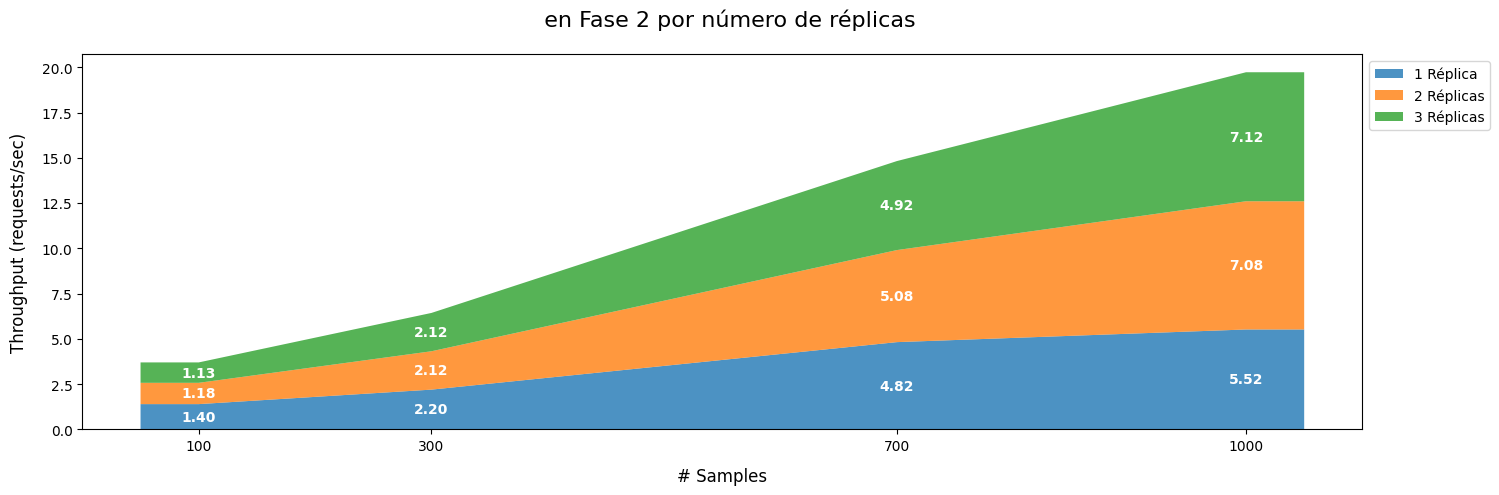

In [10]:
df = pd.read_csv('https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Jmeter/resultadosTratados.csv')

# Filtrar solo la Fase 2
fase_2 = df[df['Fase'] == 2]

# Pivotar datos
pivoted = fase_2.pivot_table(
    index='# Samples',
    columns='# Replicas',
    values='Throughput',
    aggfunc='mean'
).sort_index()

# Duplicar primer y último valor con índices extendidos
step = 50  # Cantidad de desplazamiento artificial
first_index = pivoted.index.min()
last_index = pivoted.index.max()

# Crear nuevas filas para extender el eje
extended = pd.concat([
    pd.DataFrame([pivoted.loc[first_index]], index=[first_index - step]),
    pivoted,
    pd.DataFrame([pivoted.loc[last_index]], index=[last_index + step])
])

# Crear el stackplot
plt.figure(figsize=(16, 5))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Stackplot con los valores extendidos
plt.stackplot(
    extended.index,
    extended[1], extended[2], extended[3],
    labels=['1 Réplica', '2 Réplicas', '3 Réplicas'],
    colors=colors,
    alpha=0.8
)

plt.title('  en Fase 2 por número de réplicas', fontsize=16, pad=20)
plt.xlabel('# Samples', fontsize=12, labelpad=10)
plt.ylabel('Throughput (requests/sec)', fontsize=12, labelpad=10)
plt.xticks(pivoted.index, fontsize=10)
plt.yticks(fontsize=10)

# Etiquetas de texto solo sobre los datos originales (no los extendidos)
for samples in pivoted.index:
    for i, replica in enumerate([1, 2, 3], start=1):
        y_value = pivoted.loc[samples, replica]
        y_position = y_value / 2 if i == 1 else pivoted.loc[samples, :i].sum() - y_value / 2
        plt.text(
            samples, y_position,
            f'{y_value:.2f}',
            ha='center',
            va='center',
            color='white',
            fontweight='bold'
        )

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

plt.show()

## **Comparación del % de Error por cada replica**

### **Funcion para crear las graficas**

In [11]:
def calculo_de_error(df):
  # Limpiar y convertir la columna 'Error %' a tipo numérico
  df['Error %'] = df['Error %'].astype(str).str.strip().str.replace('%', '', regex=False)
  df['Error %'] = pd.to_numeric(df['Error %'], errors='coerce')

  # Agrupar por cantidad de muestras y calcular el promedio del % de error
  grouped_avg_error = df.groupby('# Samples')['Error %'].mean()

  # Crear la gráfica de pastel
  plt.figure(figsize=(8, 8))
  colors = plt.cm.plasma(grouped_avg_error / grouped_avg_error.max())

  # Convertir colors a lista para poder modificarlo
  colors = list(colors)

  # Obtener los valores y etiquetas en orden consistente
  values = list(grouped_avg_error.values()) if isinstance(grouped_avg_error, dict) else grouped_avg_error.to_numpy()
  labels = list(grouped_avg_error.keys()) if isinstance(grouped_avg_error, dict) else grouped_avg_error.index

  # Encontrar el índice del mínimo error (asegurando que sea un índice numérico válido)
  indice_menor_error = np.argmin(values)

  # Cambiar el color de esa porción a ROJO
  colors[indice_menor_error] = [1, 0, 0, 1]  # Rojo puro

  total = sum(values)
  plt.pie(values,
          labels=[f"{samples} muestras\n{(val/total)*100:.2f}% de error"
                  for samples, val in zip(labels, values)],
          autopct='%1.2f%%',
          colors=colors)

  plt.title('Promedio de Error según cantidad de muestras')
  plt.show()

### **Para una Replica**

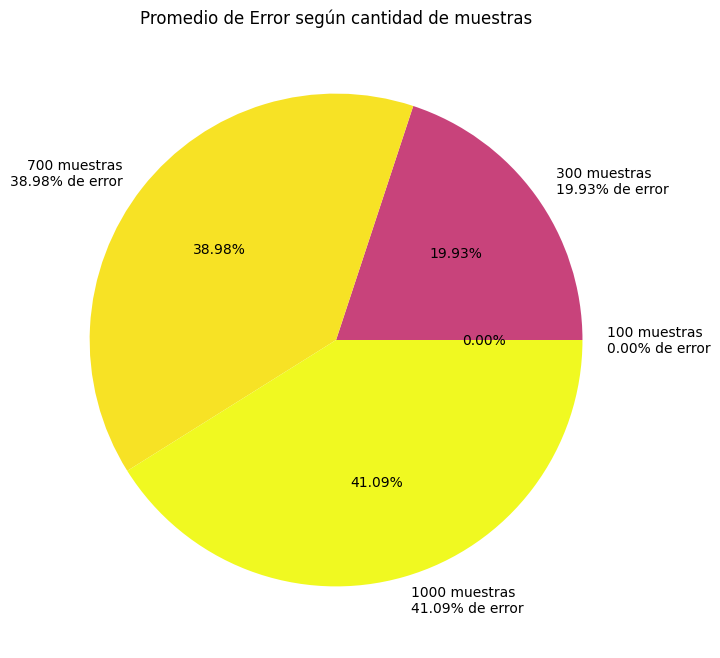

In [12]:
# Cargar los datos
df = pd.read_csv('https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Jmeter/resultadosTratados.csv')

fase_1 = df[df['Fase'] == 2]
fase_1 = fase_1[fase_1['# Replicas'] == 1]

calculo_de_error(fase_1)

### **Para dos Replicas**

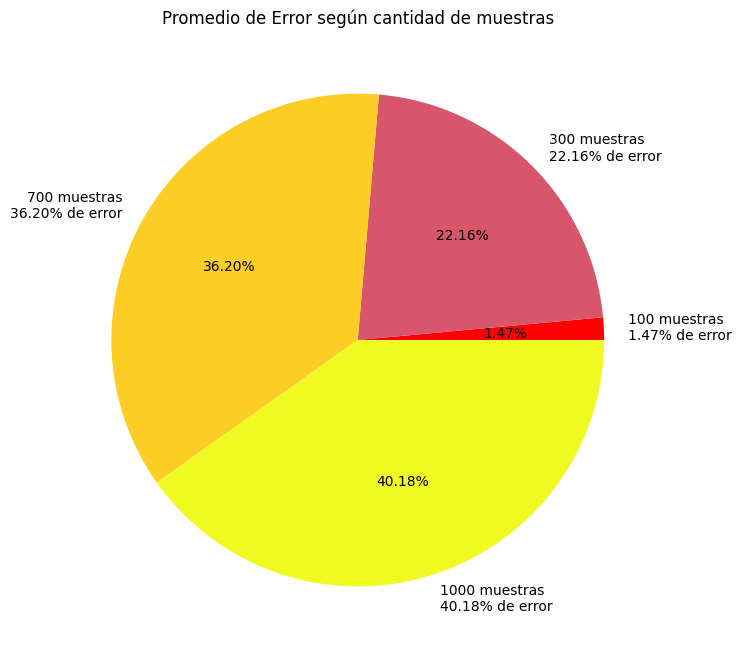

In [13]:
# Cargar los datos
df = pd.read_csv('https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Jmeter/resultadosTratados.csv')

fase_2 = df[df['Fase'] == 2]
fase_2 = fase_2[fase_2['# Replicas'] == 2]

calculo_de_error(fase_2)

### **Para tres Replicas**

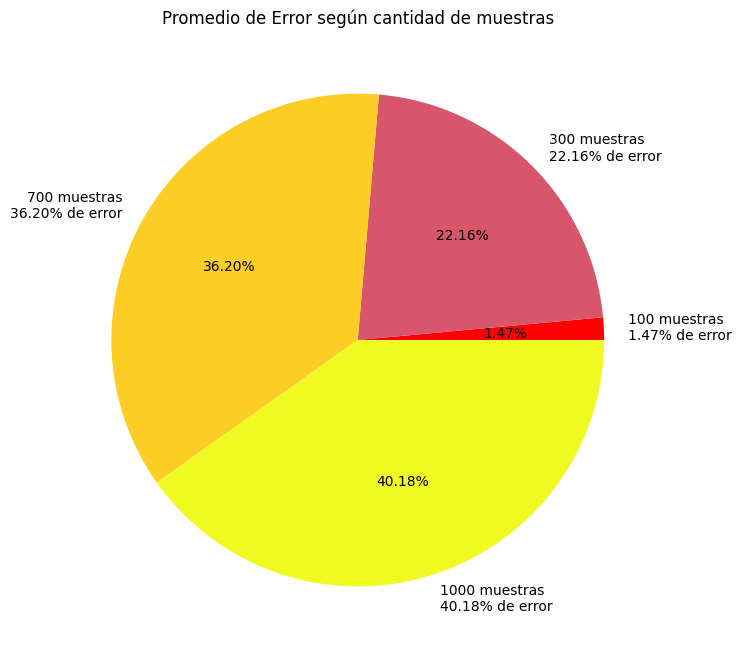

In [14]:
# Cargar los datos
df = pd.read_csv('https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Jmeter/resultadosTratados.csv')

fase_3 = df[df['Fase'] == 2]
fase_3 = fase_3[fase_3['# Replicas'] == 3]

calculo_de_error(fase_2)

## **Comparación de Throughput y Tiempo promedio de respuesta por Replica**

### **Funcion para crear las graficas**

In [15]:
def graficas_replicas(fase_1, num_fase):
  # Filtrar solo los datos de la Fase 1


  # Agrupar por '# Samples' y calcular promedios
  grouped = fase_1.groupby('# Samples').agg({
      'Throughput': 'mean',
      'Average': 'mean'
  }).sort_index()

  # Crear figura con doble eje
  fig, ax1 = plt.subplots(figsize=(10, 6))

  # Eje Y izquierdo (Throughput)
  ax1.set_xlabel('# de Muestras', fontsize=12)
  ax1.set_ylabel('Throughput (requests/sec)', color='tab:blue', fontsize=12)
  ax1.plot(grouped.index, grouped['Throughput'],
          marker='o', linestyle='-', color='tab:blue', label='Throughput')
  ax1.tick_params(axis='y', labelcolor='tab:blue')

  # Eje Y derecho (Tiempos de respuesta)
  ax2 = ax1.twinx()
  ax2.set_ylabel('Tiempo de respuesta (ms)', color='tab:red', fontsize=12)
  ax2.plot(grouped.index, grouped['Average'],
          marker='^', linestyle=':', color='tab:red', label='Average (tiempo)')
  ax2.tick_params(axis='y', labelcolor='tab:red')

  # Título y leyendas
  plt.title(f'Fase {num_fase}: Throughput y Tiempos de Respuesta por # Muestras', fontsize=14, pad=20)
  fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.85), fontsize=10)
  plt.grid(True, linestyle='--', alpha=0.6)

  for x, y in zip(grouped.index, grouped['Throughput']):
      ax1.text(x-10, y + 0.03, f'{y:.2f}',
              ha='center', va='bottom', color='tab:blue', fontsize=9)


  for x, y in zip(grouped.index, grouped['Average']):
      ax2.text(x + 15, y - 1100, f'{y:.0f}',
              ha='center', va='top', color='tab:red', fontsize=9)

  # Ajustar márgenes para evitar cortes
  plt.tight_layout()
  plt.show()

### **Para una replica**

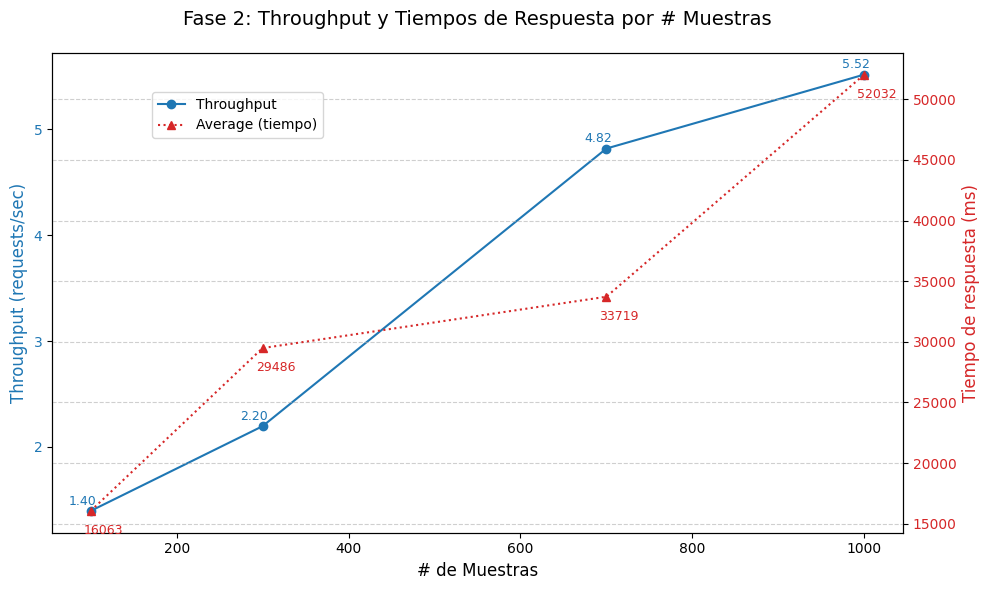

In [16]:
df = pd.read_csv('https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Jmeter/resultadosTratados.csv')
fase_1 = df[df['Fase'] == 2]
fase_1 = fase_1[fase_1['# Replicas'] == 1]

graficas_replicas(fase_1, 2)

### **Para dos Replicas**

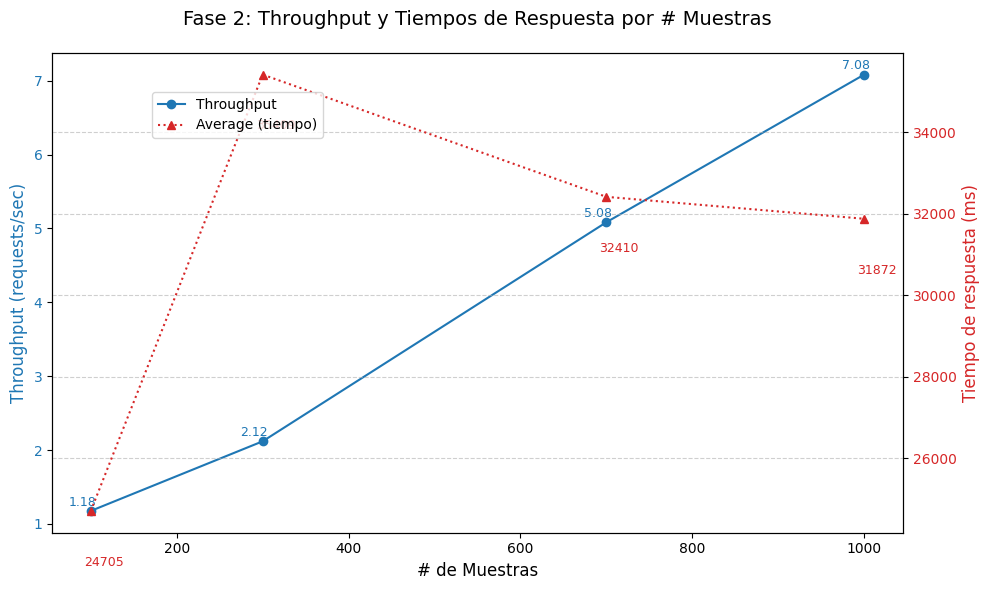

In [17]:
fase_2 = df[df['Fase'] == 2]
fase_2 = fase_2[fase_2['# Replicas'] == 2]

graficas_replicas(fase_2, 2)

### **Para tres Replicas**

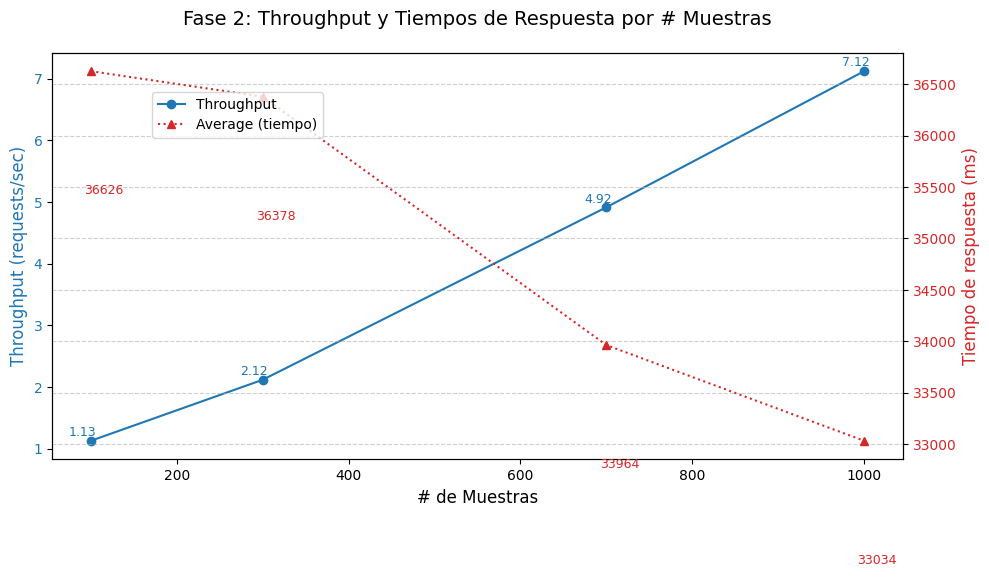

In [18]:
fase_3 = df[df['Fase'] == 2]
fase_3 = fase_3[fase_3['# Replicas'] == 3]

graficas_replicas(fase_3, 2)

## **Análisis de los resultados**

Para esta fase, se realizaron tres pruebas siguiendo el mismo procedimiento anterior, pero con una diferencia clave: en cada una se incrementó el número de réplicas del software. El objetivo fue evaluar si el manejo de carga mejoraba o no al aumentar el número de réplicas disponibles.

En primer lugar, se observa un comportamiento irregular del throughput a medida que se incrementa el número de réplicas. Entre las 100 y 300 peticiones, se presenta una disminución en la tasa de respuesta. Al llegar a 700 peticiones, se aprecia una variación notable: el throughput mejora al pasar de una a dos réplicas, pero disminuye nuevamente al agregar una tercera réplica.

En el caso de las 1000 peticiones, se evidencia una mejora progresiva en la tasa de respuesta a medida que se incrementa el número de réplicas, lo cual contrasta con el comportamiento anterior. Esta irregularidad también se ve reflejada en la tasa de errores, que tiende a aumentar progresivamente no solo con el número de réplicas, sino también con la cantidad de solicitudes realizadas.

El tiempo de respuesta muestra un patrón similar. Con una sola réplica, este aumenta conforme crece el número de peticiones. No obstante, con dos réplicas, se detecta un aumento abrupto del tiempo de respuesta a las 300 peticiones, seguido de una reducción significativa al aumentar a 700 y 1000 solicitudes. Por su parte, con tres réplicas, el tiempo de respuesta es considerablemente mayor en los primeros escenarios de 100 y 300 peticiones, pero disminuye cuando se alcanza un mayor volumen de solicitudes.

Estos resultados dejan en evidencia que aumentar el número de réplicas no siempre conduce a una mejora en el rendimiento. Es fundamental determinar cuántas réplicas son necesarias en función de la carga real del sistema. Cuando el número de réplicas excede los requerimientos del software, el servicio puede ser incapaz de distribuir eficientemente la carga, generando así resultados adversos.

# **Fase 3**

### **Comparación de Throughput cuando se trabaja con varias replicas**

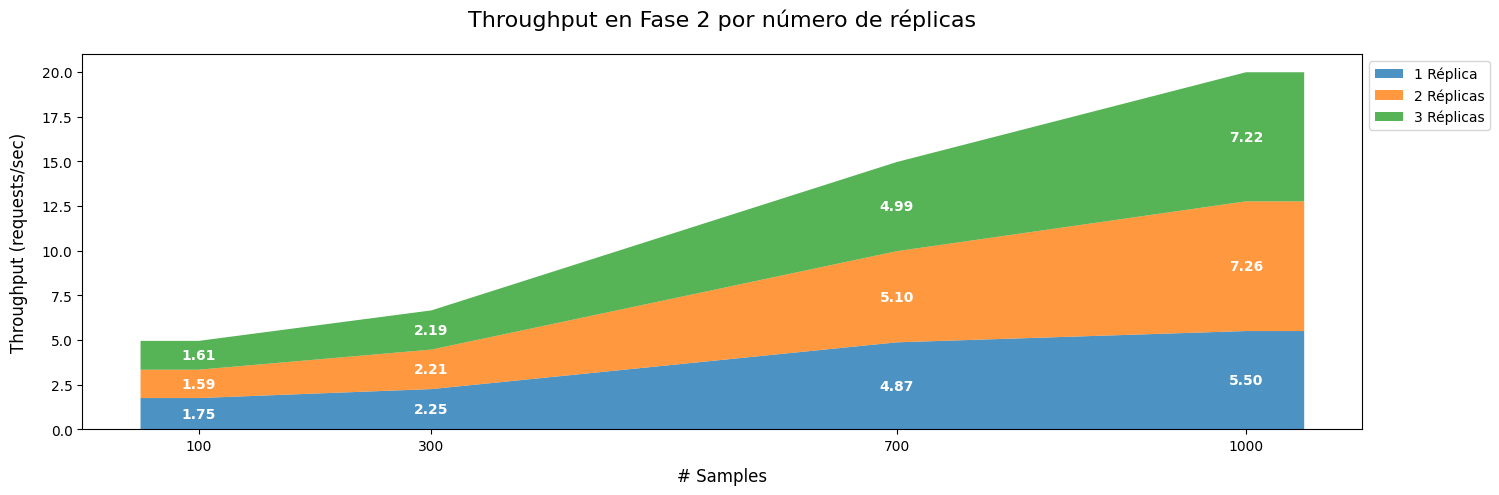

In [19]:
df = pd.read_csv('https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Jmeter/resultadosTratados.csv')

# Filtrar solo la Fase 2
fase_2 = df[df['Fase'] == 3]

# Pivotar datos
pivoted = fase_2.pivot_table(
    index='# Samples',
    columns='# Replicas',
    values='Throughput',
    aggfunc='mean'
).sort_index()

# Duplicar primer y último valor con índices extendidos
step = 50  # Cantidad de desplazamiento artificial
first_index = pivoted.index.min()
last_index = pivoted.index.max()

# Crear nuevas filas para extender el eje
extended = pd.concat([
    pd.DataFrame([pivoted.loc[first_index]], index=[first_index - step]),
    pivoted,
    pd.DataFrame([pivoted.loc[last_index]], index=[last_index + step])
])

# Crear el stackplot
plt.figure(figsize=(16, 5))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Stackplot con los valores extendidos
plt.stackplot(
    extended.index,
    extended[1], extended[2], extended[3],
    labels=['1 Réplica', '2 Réplicas', '3 Réplicas'],
    colors=colors,
    alpha=0.8
)

plt.title('Throughput en Fase 2 por número de réplicas', fontsize=16, pad=20)
plt.xlabel('# Samples', fontsize=12, labelpad=10)
plt.ylabel('Throughput (requests/sec)', fontsize=12, labelpad=10)
plt.xticks(pivoted.index, fontsize=10)
plt.yticks(fontsize=10)

# Etiquetas de texto solo sobre los datos originales (no los extendidos)
for samples in pivoted.index:
    for i, replica in enumerate([1, 2, 3], start=1):
        y_value = pivoted.loc[samples, replica]
        y_position = y_value / 2 if i == 1 else pivoted.loc[samples, :i].sum() - y_value / 2
        plt.text(
            samples, y_position,
            f'{y_value:.2f}',
            ha='center',
            va='center',
            color='white',
            fontweight='bold'
        )

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

plt.show()

## **Comparación del % de Error por cada replica**

### **Funcion para crear las graficas**

In [20]:
def calculo_de_error(df):
  # Limpiar y convertir la columna 'Error %' a tipo numérico
  df['Error %'] = df['Error %'].astype(str).str.strip().str.replace('%', '', regex=False)
  df['Error %'] = pd.to_numeric(df['Error %'], errors='coerce')

  # Agrupar por cantidad de muestras y calcular el promedio del % de error
  grouped_avg_error = df.groupby('# Samples')['Error %'].mean()

  # Crear la gráfica de pastel
  plt.figure(figsize=(8, 8))
  colors = plt.cm.plasma(grouped_avg_error / grouped_avg_error.max())

  # Convertir colors a lista para poder modificarlo
  colors = list(colors)

  # Obtener los valores y etiquetas en orden consistente
  values = list(grouped_avg_error.values()) if isinstance(grouped_avg_error, dict) else grouped_avg_error.to_numpy()
  labels = list(grouped_avg_error.keys()) if isinstance(grouped_avg_error, dict) else grouped_avg_error.index

  # Encontrar el índice del mínimo error (asegurando que sea un índice numérico válido)
  indice_menor_error = np.argmin(values)

  # Cambiar el color de esa porción a ROJO
  colors[indice_menor_error] = [1, 0, 0, 1]  # Rojo puro

  total = sum(values)
  plt.pie(values,
          labels=[f"{samples} muestras\n{(val/total)*100:.2f}% de error"
                  for samples, val in zip(labels, values)],
          autopct='%1.2f%%',
          colors=colors)

  plt.title('Promedio de Error según cantidad de muestras')
  plt.show()

### **Para una Replica**

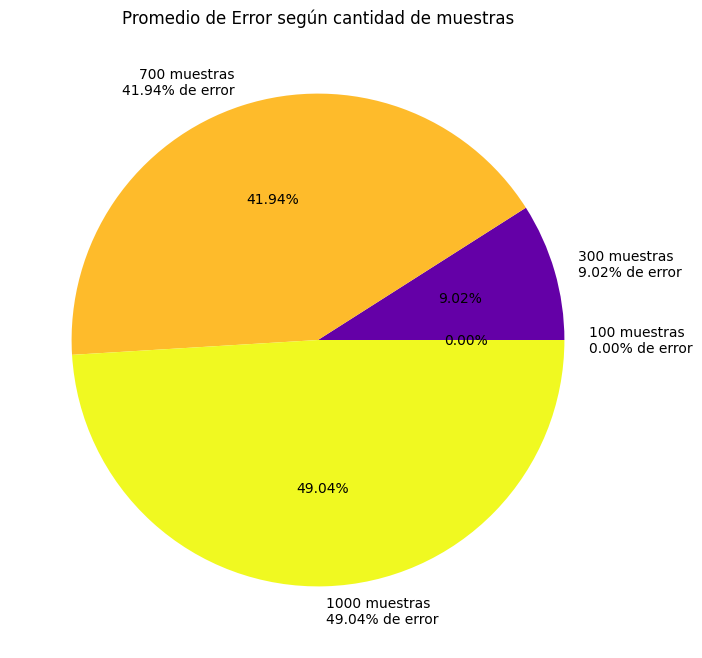

In [21]:
# Cargar los datos
df = pd.read_csv('https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Jmeter/resultadosTratados.csv')

fase_1 = df[df['Fase'] == 3]
fase_1 = fase_1[fase_1['# Replicas'] == 1]

calculo_de_error(fase_1)

### **Para dos Replicas**

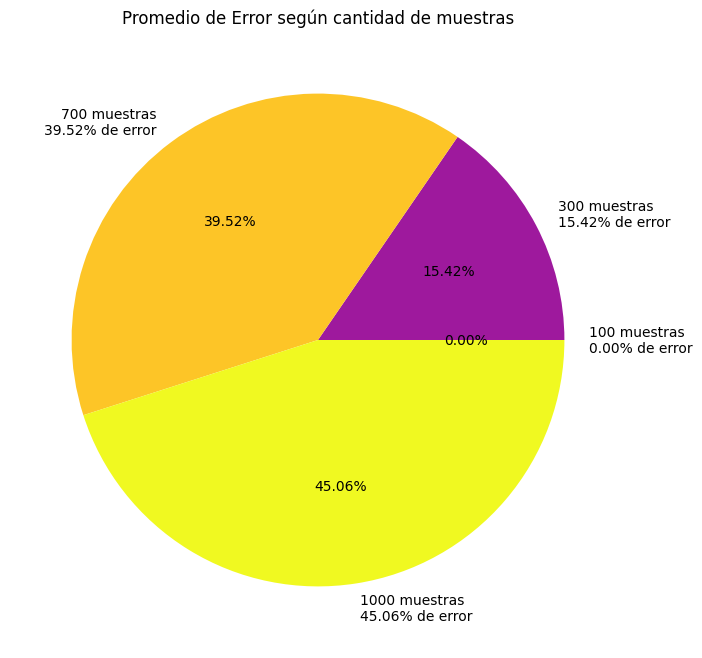

In [22]:
# Cargar los datos
df = pd.read_csv('https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Jmeter/resultadosTratados.csv')

fase_2 = df[df['Fase'] == 3]
fase_2 = fase_2[fase_2['# Replicas'] == 2]

calculo_de_error(fase_2)

### **Para tres Replicas**

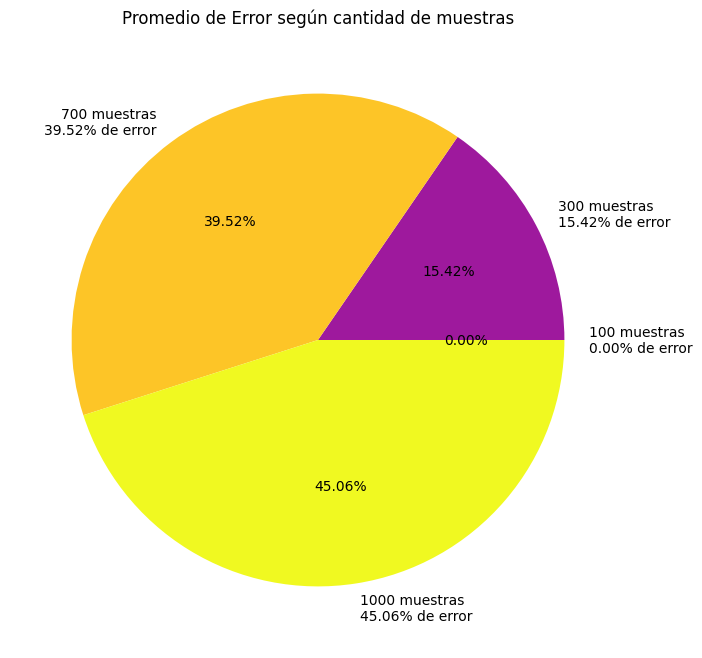

In [23]:
# Cargar los datos
df = pd.read_csv('https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Jmeter/resultadosTratados.csv')

fase_3 = df[df['Fase'] == 3]
fase_3 = fase_3[fase_3['# Replicas'] == 3]

calculo_de_error(fase_2)

## **Comparación de Throughput y Tiempo promedio de respuesta por Replica**

### **Funcion para crear las graficas**

In [24]:
def graficas_replicas(fase_1, num_fase):
  # Filtrar solo los datos de la Fase 1


  # Agrupar por '# Samples' y calcular promedios
  grouped = fase_1.groupby('# Samples').agg({
      'Throughput': 'mean',
      'Average': 'mean'
  }).sort_index()

  # Crear figura con doble eje
  fig, ax1 = plt.subplots(figsize=(10, 6))

  # Eje Y izquierdo (Throughput)
  ax1.set_xlabel('# de Muestras', fontsize=12)
  ax1.set_ylabel('Throughput (requests/sec)', color='tab:blue', fontsize=12)
  ax1.plot(grouped.index, grouped['Throughput'],
          marker='o', linestyle='-', color='tab:blue', label='Throughput')
  ax1.tick_params(axis='y', labelcolor='tab:blue')

  # Eje Y derecho (Tiempos de respuesta)
  ax2 = ax1.twinx()
  ax2.set_ylabel('Tiempo de respuesta (ms)', color='tab:red', fontsize=12)
  ax2.plot(grouped.index, grouped['Average'],
          marker='^', linestyle=':', color='tab:red', label='Average (tiempo)')
  ax2.tick_params(axis='y', labelcolor='tab:red')

  # Título y leyendas
  plt.title(f'Fase {num_fase}: Throughput y Tiempos de Respuesta por # Muestras', fontsize=14, pad=20)
  fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.85), fontsize=10)
  plt.grid(True, linestyle='--', alpha=0.6)

  for x, y in zip(grouped.index, grouped['Throughput']):
      ax1.text(x-10, y + 0.03, f'{y:.2f}',
              ha='center', va='bottom', color='tab:blue', fontsize=9)


  for x, y in zip(grouped.index, grouped['Average']):
      ax2.text(x + 15, y - 1100, f'{y:.0f}',
              ha='center', va='top', color='tab:red', fontsize=9)

  # Ajustar márgenes para evitar cortes
  plt.tight_layout()
  plt.show()

### **Para una replica**

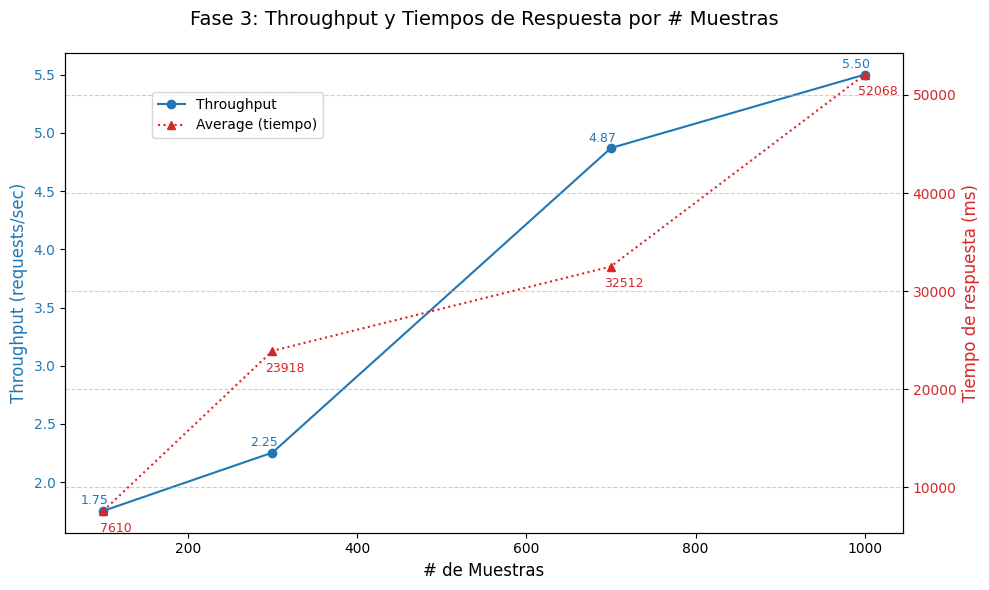

In [25]:
df = pd.read_csv('https://raw.githubusercontent.com/JuanRoa785/PF-Software-III/main/Jmeter/resultadosTratados.csv')
fase_1 = df[df['Fase'] == 3]
fase_1 = fase_1[fase_1['# Replicas'] == 1]

graficas_replicas(fase_1, 3)

### **Para dos Replicas**

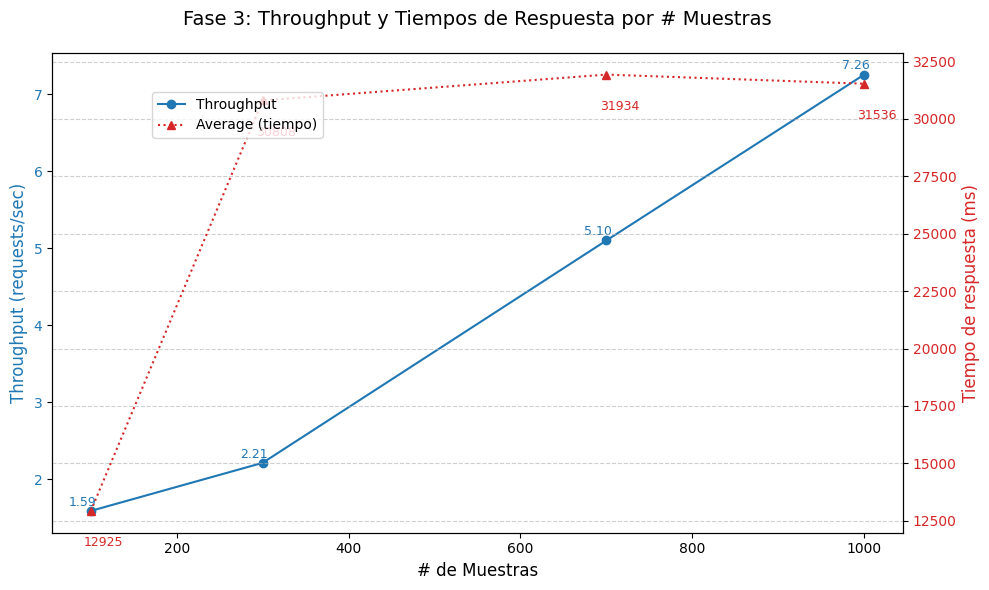

In [26]:
fase_2 = df[df['Fase'] == 3]
fase_2 = fase_2[fase_2['# Replicas'] == 2]

graficas_replicas(fase_2, 3)

### **Para tres Replicas**

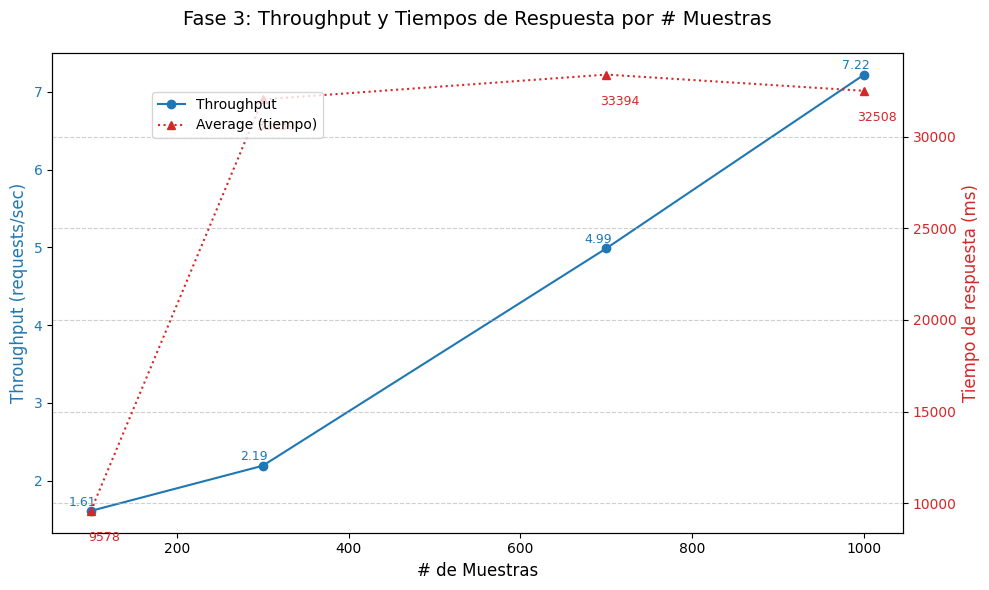

In [27]:
fase_3 = df[df['Fase'] == 3]
fase_3 = fase_3[fase_3['# Replicas'] == 3]

graficas_replicas(fase_3, 3)

## **Análisis de los resultados**

Para esta prueba se siguió el mismo procedimiento que en las dos fases anteriores. En este caso, al utilizar dos nodos y variar el número de réplicas, se observa que en las primeras 100 y 300 solicitudes hay una disminución clara del throughput a medida que se incrementa el número de réplicas. Sin embargo, al llegar a las 700 y 1000 solicitudes, el throughput mejora al pasar de una a dos réplicas, pero vuelve a disminuir al incorporar una tercera réplica.

En cuanto a la tasa de errores, se presenta un comportamiento diferente. Para las 100 solicitudes, el error se mantiene constante independientemente del número de réplicas. En el caso de las 300 solicitudes, la tasa de error aumenta al pasar de una a dos réplicas, pero se estabiliza al añadir una tercera. Para 700 y 1000 peticiones, se observa una disminución significativa del error al pasar de una a dos réplicas, manteniéndose luego constante con tres réplicas.

Respecto al tiempo de respuesta, en esta tercera fase se presenta un patrón similar al observado en la fase anterior para una sola réplica: el tiempo de respuesta aumenta progresivamente con el número de peticiones. En los escenarios con dos y tres réplicas, se aprecia un incremento abrupto del tiempo entre las 100 y 300 solicitudes, seguido por un aumento más moderado a las 700 y una leve disminución al alcanzar las 1000 solicitudes.

Esta fase revela una problemática similar a la de la fase 2: los tiempos de respuesta son más elevados con una menor cantidad de solicitudes, independientemente de si se emplea una, dos o tres réplicas. Esto sugiere que Kubernetes enfrenta mayores dificultades para distribuir eficientemente la carga cuando los recursos disponibles exceden la demanda real del software en un entorno con dos nodos. Se refuerza así la importancia de conocer las necesidades del sistema para asignar los recursos adecuados en función de la carga esperada, evitando tanto el subdimensionamiento como el sobredimensionamiento.

# **Conclusión**

Las pruebas de carga realizadas al software bajo diferentes condiciones evidencian la importancia de conocer con precisión la demanda que tendrá nuestra aplicación para poder asignar los recursos adecuados. Si esto no se considera, la incorporación de más nodos o réplicas no solo puede resultar ineficaz, sino que también podría generar un aumento en el tiempo de respuesta y en la tasa de errores.

Uno de los hallazgos clave de las pruebas es que, ante una mayor demanda de recursos, resulta más eficiente emplear una arquitectura con dos nodos y tres réplicas. Este enfoque no solo reduce el tiempo de respuesta en todos los escenarios evaluados (100, 300, 700 y 1000 peticiones), sino que también mejora el throughput en comparación con la configuración de un solo nodo con tres réplicas.